In [1]:
    # From lab5(previous codes)
import sys
import numpy as np
import matplotlib
import librosa
from matplotlib import pyplot as plt
import librosa.display

#from scipy.io import wavfile
from scipy import signal
from scipy.fft import fftshift
from IPython.display import Audio
import soundfile

Fs=16000
Nf=int(0.02*Fs)
Ns=int(0.01*Fs)
Tover=0.003
Nover=int(Fs*Tover) # overlap될 길이 (trapezoidal의 사용을 위해 정의됨)
upslope=np.linspace(0,1,Nover+2)[1:-1]

def getFIRFFT(H,order, flag_window=1, flag_display=0):
        
        NFFT=len(H)*2-1
        # real 부분을 뒤집어서 pi~ 2pi부분에 넣는다.
        mirrored=np.concatenate([H,np.flip(np.conjugate(H[0:-1]),axis=0)],axis=0)
        mirrored=mirrored+(0j)
        
        # 중앙을 기준으로 좌우 대칭인 것을 ifft한다.
        iffted=np.fft.ifft(mirrored, axis=0)
        iffted=np.concatenate([iffted[len(H):], iffted[0:len(H)]])
    
        if flag_display==1: # 디버깅용 플롯
            plt.figure()
            plt.plot(np.arange(len(mirrored))*np.pi*2/len(mirrored),mirrored)
            plt.title("Mirrored time-domain signal")
    
            plt.figure()
            plt.plot(np.arange(len(iffted)),np.real(iffted))
            plt.title("iffted signal")
            
        # 원하는 order에 해당하는 만큼만 잘라낸다.
        h=iffted[len(H)-order//2:len(H)+order//2 ]
        h=h.real
        
        if flag_window ==1: # 필요하다면 hamming window를 적용한다.
            window=signal.windows.hamming(len(h))
            h=h*window    
        return h
    
def Spectrogram(x,Ns,Nf,flag_hamm):
        # x : 음성신호
        # Ns: shift number of samples
        # Nf: frame number of samples
        # flag_hmm: switch for hamming window 1/0 (ON/OFF)
        T = len(x)   # number of samples
        #num_frames = T//Nf# 마지막 채워지지 않은 프레임은 버린다. 구현에 따라 zero-padding해서 사용 가능
        num_frames = (T-Nf)//Ns + 1 
        hNo = Nf//2+1
    
        X = np.zeros((hNo,num_frames),dtype='complex')
        
        if flag_hamm >0: # window setting
            win = librosa.filters.get_window('hamming', Nf, fftbins=True)
        else:
            win = np.ones(Nf)
            
        for i in range(num_frames):
            y = x[(i*Ns):(i*Ns+Nf)]
    
            y=np.fft.fft(y*win) 
            X[:,i]= y[:hNo]
    
        return X
    
def filtering(h, x, prevx,out_len):# 필터링 후 원하는 길이만큼 출력해주는 함수
        # h : 시간차원 필터
        # x : 시간차원 신호
        # prevx : 버퍼 초기화
        # out_len : 원하는 출력 길이
        Lx=len(x)
        x_i=np.concatenate([prevx,x])
        y=np.convolve(x_i,h,"same")
        
        prevx=x_i[-len(prevx):]
        
        return y[-out_len:], prevx
    
def get_Wiener_filter(E_x,Ns,Nf,order,E_n): # wiener filter를 구해주는 함수
        # E_x : spectrum Energy
        # Ns: shift할 길이
        # Nf: 프레임의 크기
        # order: wiener filter의 크기
        # E_n : 추정된 noise의 주파수 특성
        H=(E_x-E_n)/E_x
        H[H < 0.000001]=0.000001 # clipping
        h=getFIRFFT(H,order,0) # time-domain filter
        
        return h
def trapezoidal_mixing(f_idx,Nover,y,y_tmp,upslope): # trapezoidal mixing을 해주는 함수
        # f_idx : 현재 프레임 번호
        # Nf : 프레임의 길이
        # Nover : overlap될 길이
        # y : 결과를 저장할 배열
        # y_tmp : 입력된 데이터
        # upslope : mixing할 가중치 배열
        if (f_idx-1)*Ns-Nover>=0: # trapezoidal window의 적용
            y[(f_idx-1)*Ns-Nover:(f_idx-1)*Ns]=y[(f_idx-1)*Ns-Nover:(f_idx-1)*Ns]+upslope*y_tmp[:Nover]
            y[(f_idx-1)*Ns:(f_idx)*Ns]=y_tmp[Nover:]
            y[(f_idx)*Ns-Nover:(f_idx)*Ns]=y[(f_idx)*Ns-Nover:(f_idx)*Ns]*np.flip(upslope)
        else:
            y[(f_idx-1)*Ns:(f_idx)*Ns]=y_tmp[Nover:]
            y[(f_idx)*Ns-Nover:(f_idx)*Ns]=y[(f_idx)*Ns-Nover:(f_idx)*Ns]*np.flip(upslope)        
        return y
def median_filtering(x,L_filter,prevx): # median을 계산하는 필터
        # x : 시간차원의 신호
        # L_filter : median필터의 길이
        # prevx : 필터링 버퍼
    
        x_i= np.concatenate([prevx,x])
        N_frame=int(len(x_i)/L_filter)
        y=np.zeros(len(x))
        for idx in range(len(x)-L_filter):
            y[idx]=np.median(x_i[(idx):idx+L_filter])

        prevx=x_i[-len(prevx):]
        return y,prevx
    
def gaussian(x,mu,std2):
        return np.exp(-(x-mu)**2/(2*std2))/np.sqrt(2*np.pi*std2)
    
def rayleigh(x,sig2): # rayleigh distribution
        # x : 입력 데이터
        # sig2 : 파라미터 sig의 제곱    
        return np.exp(np.sum(np.log(x)/2,axis=0)-np.sum(np.log(sig2),axis=0)-np.sum((x)/(2*sig2),axis=0))

def EM_Rayleigh(y_k,sig_x,sig_n,P_voice): # 다변수 rayleigh distribution의 EM알고리즘
        # y_k : 입력 데이터
        # sig_x : 음성신호의 파라미터 sig의 제곱    
        # sig_n : 노이즈의 파라미터 sig의 제곱 
        # P_voice : 음성이 있을 확률
        prob= lambda x,sig2 : np.exp(np.sum(np.log(x),axis=0)-np.sum(np.log(sig2),axis=0)-np.sum((x**2)/(2*sig2),axis=0))
        gamma=lambda fx,fy,P_voice : 1/(1+(1-P_voice)*fy/(P_voice*fx))
        for iter in range(10):
            Px=prob(y_k,sig_x)# fx(y)
            Pn=prob(y_k,sig_n)# fn(y)
            P_v=gamma(Px,Pn,P_voice).reshape(1,-1)# P(voice | y)

            for idx in range(P_v.size):
                if int(np.isnan(P_v[0,idx])):
                    if idx < P_v.size*P_voice:
                        P_v[0,idx]=0
                    else:
                        P_v[0,idx]=1        
            P_voice=np.mean(P_v)
            sig_x=(np.mean(P_v*(y_k),axis=-1)/(2*P_voice)).reshape(-1,1)
            sig_n=(np.mean((1-P_v)*(y_k),axis=-1)/(2-2*P_voice)).reshape(-1,1)
        return P_v, sig_x, sig_n, P_voice

def EM_Rayleigh_FB(Y,P_voice=None,sig_x2=None,sig_n2=None):
        # Y : Spectrum energy 
        y_k=np.abs(Y)
        # y_k[y_k<1e-5]=1e-5
        if P_voice ==None:
            P_voice=0.5
        y_k.sort(axis=-1)
        max_iter=y_k.shape[-1]
        # 파라미터 sigma의 추정
        if sig_n2 == None:
            sig_n2=np.mean(y_k[:,:int(max_iter*P_voice)],axis=-1)/2
        if sig_x2 == None:
            sig_x2=np.mean(y_k[:,int(max_iter*P_voice):],axis=-1)/2

        sig_x2=sig_x2.reshape(-1,1)
        sig_n2=sig_n2.reshape(-1,1)
        P_v,sig_x,sig_n,P_voice=EM_Rayleigh(y_k,sig_x2,sig_n2,P_voice) # EM 알고리즘
        return sig_x,sig_n,P_voice
    
def Soft_Decision(P_voice,P_n,P_x):
        denom=(1-P_voice)*P_n+P_voice*P_x
        Result=(1-P_voice)*P_n/denom
        if np.isnan(Result) and (1-P_voice)*P_n> 0: # denom -> 0 이라면, Result -> inf 니까
            Result=1         # 최대값에 대한 제한이 필요하다.
        return Result


---
## Part 1. Uniform / mel-scale filter bank

#### Filterbank functions

Text(0.5, 0, 'Bin number')

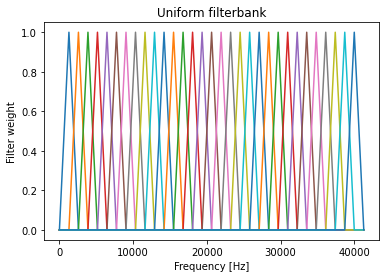

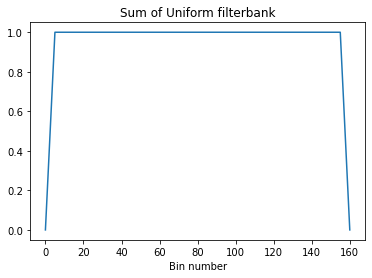

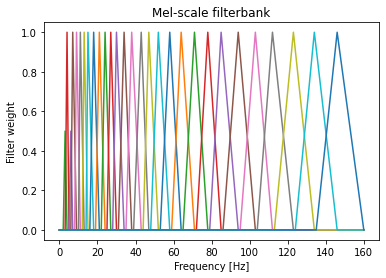

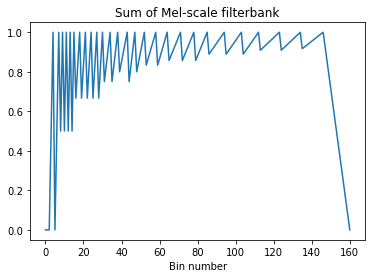

In [2]:
def uniform_filter_bank(N_fb,N_freq): # uniform filter bank
    # N_fb : # of filterbank
    # NN_freq : # of frequency bins
    band_fb=int(N_freq/(N_fb+1))
    Result=np.zeros((N_fb,N_freq))
    upslope=np.linspace(0,1,band_fb+1)
    triang=np.concatenate([upslope,np.flip(upslope[:-1])])
    for fb_idx in range(N_fb):
        Result[fb_idx,int(fb_idx*band_fb):int(fb_idx*band_fb)+band_fb*2+1]=triang
    return Result

def freq2mel(f): # convert freq to mel
    return 2595*np.log10(1+f/700)

def mel2freq(mel): # convert mel to freq
    return (10**(mel/2595)-1)*700

def mel_filter_bank(N_fb,N_freq,Fs_half):# mel-scale filterbank 
    # N_fb : # of filterbank
    # NN_freq : # of frequency bins
    # Fs_half : Nyquist frequency [Hz]
    
    # mel-scale uniform sampling
    # for choose center mels.
    mel_max=freq2mel(Fs_half)
    mels_center=np.linspace(0,mel_max,N_fb+2)

    # mels -> frequency bin index
    f_center=mel2freq(mels_center)*N_freq/(Fs_half)
    Result=np.zeros((N_fb,N_freq))
    
    for fb_idx in range(1,len(f_center)-1):
        # between the bin idxs, set the weights to triangular weights 
        delta_f_l=int(f_center[fb_idx])-int(f_center[fb_idx-1])
        delta_f_r=int(f_center[fb_idx+1])-int(f_center[fb_idx])
        upslope=np.linspace(0,1,delta_f_l)
        dwnslope=np.linspace(1,0,delta_f_r+1)[1:]
        triang=np.concatenate([upslope,dwnslope])
        Result[fb_idx-1,int(f_center[fb_idx-1]):int(f_center[fb_idx-1])+len(triang)]=triang
    return Result
#########################################################################

# Uniform filterbank Test
N_fb=31
FB=uniform_filter_bank(N_fb,161) 
plt.figure()
for row in range(FB.shape[0]):
    plt.plot(np.arange(FB.shape[-1])*Fs//2/N_fb,FB[row,:])
plt.title("Uniform filterbank")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Filter weight")

plt.figure()
plt.plot(np.arange(FB.shape[-1]),np.sum(FB,axis=0))
plt.title("Sum of Uniform filterbank")
plt.xlabel("Bin number")
#########################################################################

# Mel-scaled filterbank Test

FB=mel_filter_bank(31,161,Fs/2)
plt.figure()
for row in range(FB.shape[0]):
    plt.plot(np.arange(FB.shape[-1]),FB[row,:])

plt.title("Mel-scale filterbank")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Filter weight")

    
plt.figure()
plt.plot(np.arange(FB.shape[-1]),np.sum(FB,axis=0))
plt.title("Sum of Mel-scale filterbank")
plt.xlabel("Bin number")


<ipython-input-3-a9d327505223>:85: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.arange(len(E_n_u)),10*np.log10(E_n_u))
<ipython-input-3-a9d327505223>:86: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.arange(len(E_n_m)),10*np.log10(E_n_m))


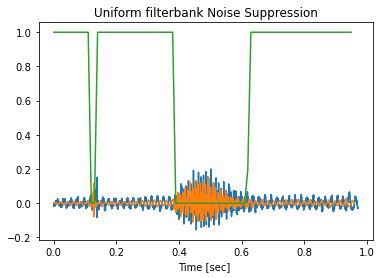

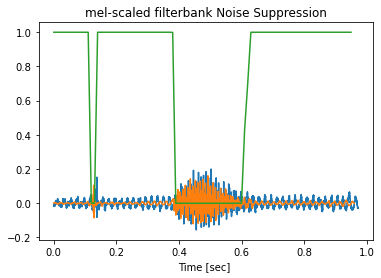

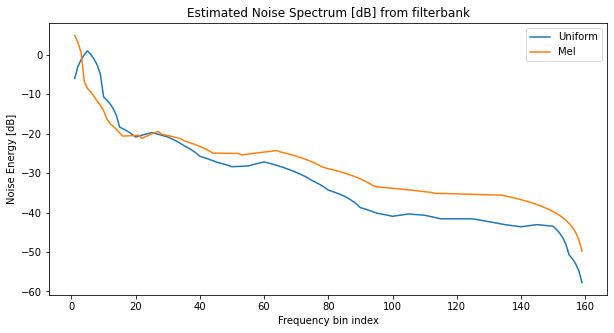

In [3]:
def kdigit_pair_list(num_digits=10,num_trial=10): # make data pairs
    # this function returns file paths
    file_list=[]
    for d_idx in range(num_digits):
        for t_idx in range(num_trial):
            filename='/{}/kdigits{}-{}.wav'.format(str(d_idx),str(t_idx),str(d_idx))
            file_list.append((filename,d_idx))
    return file_list

def plot_ns(x,y,Decision,keys=""): # Visualization function 
    plt.plot(np.arange(len(x))/Fs,x)
    plt.plot(np.arange(len(y))/Fs,y)
    plt.plot(np.arange(len(Decision))*Ns/Fs,Decision)
    plt.xlabel("Time [sec] ")
    plt.title("{} Noise Suppression".format(keys))

    
def Noise_suppression(data,Fs,fb):
    x,Fs=librosa.load(data[0],sr=Fs)
    X=Spectrogram(x,Ns,Nf,1)
    X=(np.conj(X)*X).real
    
    E_fb=np.matmul(fb,X)
    
    sig_x,sig_n,P_voice=EM_Rayleigh_FB(E_fb,P_voice=None,sig_x2=None,sig_n2=None)
    Decision=np.zeros(X.shape[-1])
    mem_x=np.zeros(order-1+Nover)
    y=np.zeros(X.shape[-1]*Ns)
    for t_idx in range(X.shape[-1]):
        x_i=x[Ns*t_idx:Ns*t_idx+Nf]
        X_i=E_fb[:,t_idx].reshape(-1,1)
        Decision[t_idx]=Soft_Decision(P_voice,
                      rayleigh(X_i,sig_n),
                      rayleigh(X_i,sig_x)
                     )
        E_n_hat=np.matmul(fb.T,sig_n.reshape(-1,1))
        h_soft=get_Wiener_filter(X[:,t_idx],Ns,Nf,order,E_n_hat.reshape(-1))
        y_tmp, mem_x=filtering(h_soft,x_i,mem_x,Ns+Nover)
        y=trapezoidal_mixing(t_idx+1,Nover,y,y_tmp,upslope)
    return x,y,Decision,E_n_hat

data_path='proj1/segmented-val/nbnSNR0/chlee' # Test folder root
file_list=kdigit_pair_list()

N_fb=31

order=30

fb_uniform=uniform_filter_bank(N_fb,Nf//2+1) # 31 uniform filterbank
fb_mel=mel_filter_bank(N_fb//2,Nf//2+1,Fs//2)# 15 mel-scaled filterbank

Data=[(data_path+x,y) for (x,y) in file_list]

data_idx=0
data_idx=int(data_idx % len(Data))
data=Data[data_idx]

############################################################################

# noise supperssion system (shown in right below)
# x[t] -> Spectrogram -> Uniform filterbank -> *
# * -> EM algorithm -> Wiener filtering 

x,y,Decision,E_n_u=Noise_suppression(data,Fs,fb_uniform)
plt.figure()
plot_ns(x,y,Decision,"Uniform filterbank")

############################################################################

# noise supperssion system (shown in right below)
# x[t] -> Spectrogram -> Mel-scaled filterbank -> *
# * -> EM algorithm -> Wiener filtering 


x,y,Decision,E_n_m=Noise_suppression(data,Fs,fb_mel)
plt.figure()
plot_ns(x,y,Decision,"mel-scaled filterbank")
    

##################################################################

# filterbank results

plt.figure(figsize=[10,5])
plt.plot(np.arange(len(E_n_u)),10*np.log10(E_n_u))
plt.plot(np.arange(len(E_n_m)),10*np.log10(E_n_m))
plt.title("Estimated Noise Spectrum [dB] from filterbank")
plt.xlabel("Frequency bin index")
plt.ylabel("Noise Energy [dB]")
plt.legend(['Uniform','Mel'])




---
## Part 2 : DTW algorithm
#### 아래의 링크에서 정의한 DTW함수를 사용했다.
#### https://hamait.tistory.com/862

In [4]:
# import dtw

# def Template_Comparision(Data,Templates):
#     N_temp=len(Templates)
#     N_data=len(Data)
#     DTW_table=np.zeros((N_temp,N_data))
#     for d_idx in range(N_data):
#         data,_=librosa.load(Data[d_idx][0],sr=Fs,mono=True)
#         for t_idx in range(N_temp):
#             tmp,_=librosa.load(Templates[t_idx][0],sr=Fs,mono=True)
# #             DTW_table[d_idx,t_idx]=DTW(data,tmp)
#             DTW_table[d_idx,t_idx]=dtw.dtw(data,tmp,keep_internals=True).distance
#         print("data[{}] done!".format(d_idx))
    
#     Result=np.argmin(DTW_table,axis=1)
#     Results=np.array([Data[x][1] for x in Result])
    
#     return DTW_table,Results

#### DTW의 시간이 너무 오래 걸려서 결과를 확인할 수는 없었지만, 아래의 코드로 Wraping을 이용할 수 있을 것이라 기대된다.

In [ ]:


from math import *
import numpy as np
import dtw

from math import *
import numpy as np

def DTW(A, B, window=None, d=lambda x, y: np.abs(x - y)):
    if window is None:
        window=min(len(A),len(B))
    # 비용 행렬 초기화 
    A, B = np.array(A), np.array(B)
    M, N = len(A), len(B)
    cost = 9999999 * np.ones((M, N))
    # 첫번째 로우,컬럼 채우기
    cost[0, 0] = d(A[0], B[0])
    for i in range(1, M):
        cost[i, 0] = cost[i - 1, 0] + d(A[i], B[0])

    for j in range(1, N):
        cost[0, j] = cost[0, j - 1] + d(A[0], B[j])
    # 나머지 행렬 채우기 
    for i in range(1, M):
        for j in range(max(1, i - window), min(N, i + window)):
            choices = cost[i - 1, j - 1], cost[i, j - 1], cost[i - 1, j]
            cost[i, j] = min(choices) + d(A[i], B[j])

    # 최적 경로 구하기 
#     n, m = N - 1, M - 1
#     path = []

#     while (m, n) != (0, 0):
#         path.append((m, n))
#         m, n = min((m - 1, n), (m, n - 1), (m - 1, n - 1), key=lambda x: cost[x[0], x[1]])

#     path.append((0, 0))
    return cost[-1, -1]


def Template_Comparision(Data,Templates):
    N_temp=len(Templates)
    N_data=len(Data)
    DTW_table=np.zeros((N_temp,N_data))
    for d_idx in range(N_data):
        data,_=librosa.load(Data[d_idx][0],sr=Fs,mono=True)
        for t_idx in range(N_temp):
            tmp,_=librosa.load(Templates[t_idx][0],sr=Fs,mono=True)
            DTW_table[d_idx,t_idx]=DTW(data,tmp)
        print("data[{}] done!".format(d_idx))
    
    Result=np.argmin(DTW_table,axis=1)
    Results=np.array([Data[x][1] for x in Result])
    
    return DTW_table,Results

labels_train = {'11jeonghy', 
                'Dandyst', 
                'InkooJeon',
                'YouYeNa',
#                 'deokkyukwon',
#                 'ohjihyeon',
                'son',
               }
trainroot='segmented-train'
valroot = 'segmented-val/org'
labels_val = {
                'chlee',
                'do',
#                 'kyeong',
               }

val_root='proj1/segmented-val/nbnSNR10/'+list(labels_val)[-1] # Val data root
train_root='proj1/segmented-train/'+list(labels_train)[-1]

file_list=kdigit_pair_list()

Data_train=[(train_root+x,y) for (x,y) in file_list]
Data_val=[(val_root+x,y) for (x,y) in file_list]

DTW_table,predicted=Template_Comparision(Data_val,Data_train)

GT_digits=np.array([y for (x,y) in Data_val])

acc=sum((GT_digits-predicted) == 0) /len(Data_val)

plt.figure()
plt.stem(predicted)
plt.stem(GT_digits)
plt.title("Ground Truth & DTW results")
plt.ylabel("digit")
plt.xlabel("Data index")

print("accuracy: {}",acc)

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [ ]:
print(labels_val[0])